# Lab Session 1: Introduction to NLP for Social Science

## 0. Installation

Before we begin, let's install the necessary packages for this lab. Run the following cell to install the required libraries:


In [16]:
%pip install nlp4ss
!python -m spacy download en_core_web_sm

## 1. Introduction

In this lab, we'll apply the fundamental NLP techniques and preprocessing methods we learned in Session 1 to analyze Sierra Club press releases. We'll focus on text cleaning, normalization, and basic NLP tasks.

## 2. Setup and Data Loading

First, let's set up our environment and load the data using the provided code.


In [17]:
from hyfi import HyFI

if HyFI.is_colab():
    HyFI.mount_google_drive()
    project_root="/content/drive/MyDrive/courses/nlp4ss"
else:
    project_root="$HOME/workspace/courses/nlp4ss"

h = HyFI.initialize(
    project_name="nlp4ss",
    project_root=project_root,
    logging_level="INFO",
    verbose=True,
)

print("project_dir:", h.project.root_dir)
print("project_workspace_dir:", h.project.workspace_dir)

raw_data_file = h.project.workspace_dir / "data/raw/articles.jsonl"
rdata = h.load_dataset("json", data_files=raw_data_file.as_posix())
rdata_df = rdata["train"].to_pandas()

# Display basic information about the dataset
print(rdata_df.info())
print("\nSample of the data:")
print(rdata_df.head())

INFO:hyfi.utils.notebooks:Google Colab not detected.
INFO:hyfi.utils.notebooks:Extension autotime not found. Install it first.
INFO:hyfi.joblib.joblib:initialized batcher with <hyfi.joblib.batcher.batcher.Batcher object at 0x16fea3020>
INFO:hyfi.main.config:HyFi project [nlp4ss] initialized


project_dir: /Users/yj.lee/workspace/courses/nlp4ss
project_workspace_dir: /Users/yj.lee/workspace/courses/nlp4ss/workspace
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6354 entries, 0 to 6353
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      6354 non-null   object
 1   timestamp  6354 non-null   object
 2   url        6354 non-null   object
 3   page_url   6354 non-null   object
 4   page       6354 non-null   int64 
 5   content    6354 non-null   object
 6   uuid       6354 non-null   object
dtypes: int64(1), object(6)
memory usage: 347.6+ KB
None

Sample of the data:
                                               title       timestamp  \
0  Sierra Club Urges Commerce Department to Hold ...  April 15, 2024   
1  Sierra Club Statement on BOEM Financial Assura...  April 15, 2024   
2  We Energies Files Third Rate Increase in Three...  April 15, 2024   
3  MEDIA ADVISORY: Oregon Regulators to Hear Conc... 

## 3. Required Libraries

Now that we have our data loaded, let's import the additional libraries we'll need for our analysis:


In [18]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import spacy
from textblob import TextBlob

# Download necessary NLTK data
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /Users/yj.lee/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yj.lee/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/yj.lee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 4. Text Preprocessing

Let's create functions for various preprocessing steps.


In [19]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.lower()

def tokenize_text(text):
    return word_tokenize(text)

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]

def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def preprocess_text(text):
    text = clean_text(text)
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return ' '.join(tokens)

# Apply preprocessing to the 'content' column
rdata_df['processed_content'] = rdata_df['content'].apply(preprocess_text)
print(rdata_df['processed_content'].head())


0    april contact ada recinos deputy press secreta...
1    april contact ian brickey ianbrickeysierraclub...
2    april contact megan wittman meganwittmansierra...
3    april contact kim petty sierra club kimpettysi...
4    april contact lee ziesche leezieschesierraclub...
Name: processed_content, dtype: object


## 5. Basic NLP Tasks

Now, let's perform some basic NLP tasks on our preprocessed data.

### 5.1 Word Frequency Analysis


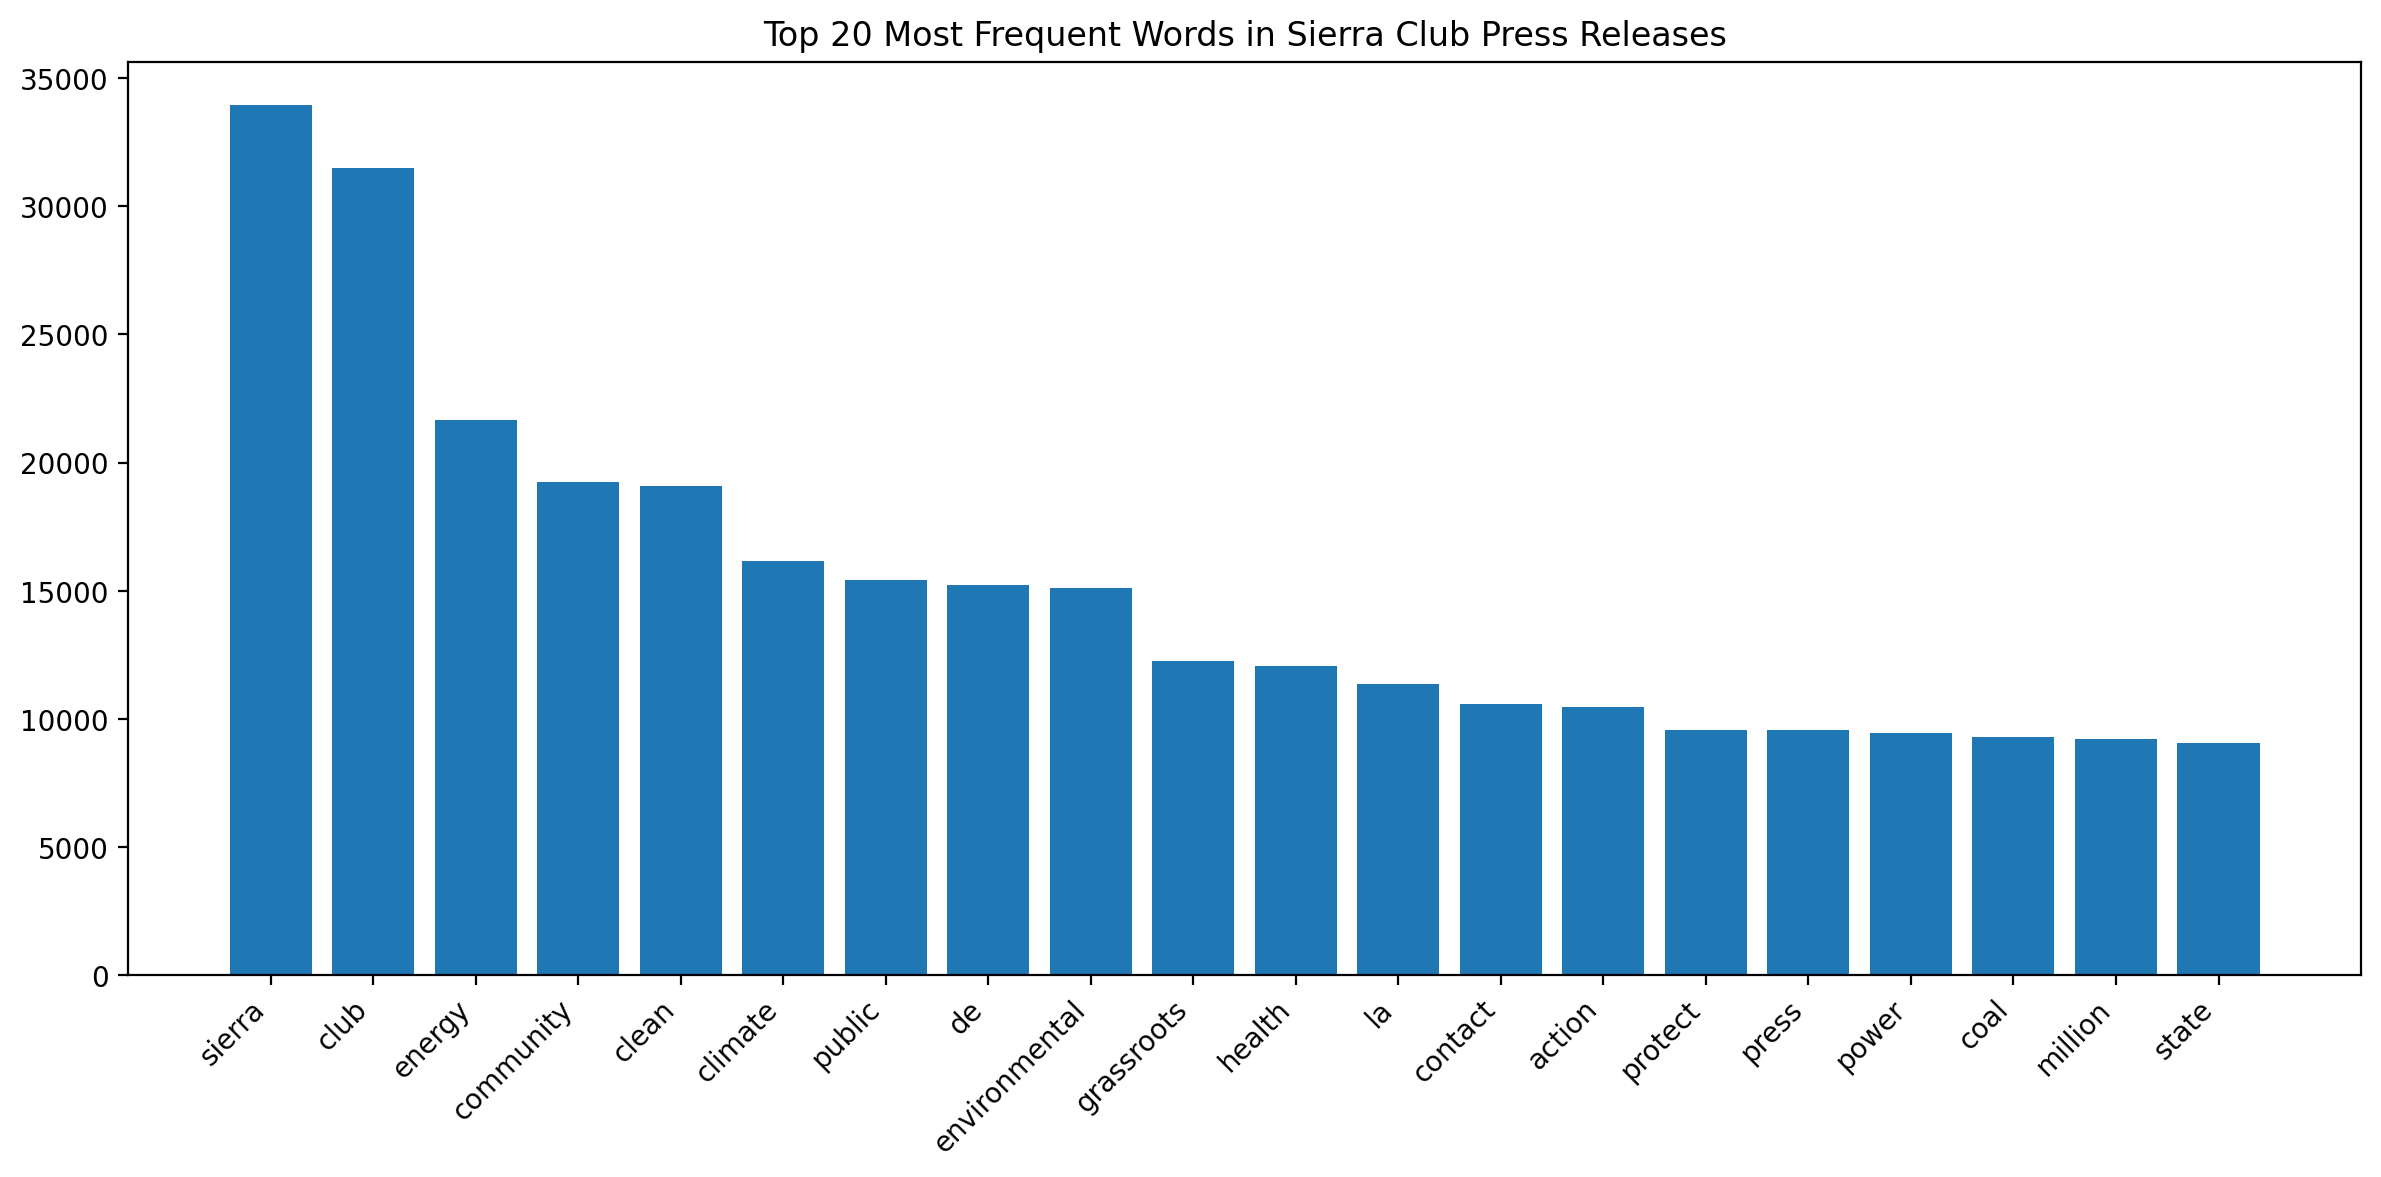

In [20]:
def get_word_freq(text):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([text])
    words = vectorizer.get_feature_names_out()
    freqs = X.toarray()[0]
    return dict(zip(words, freqs))


# Get word frequencies for all processed content
all_text = " ".join(rdata_df["processed_content"])
word_freq = get_word_freq(all_text)

# Plot top 20 most frequent words
plt.figure(figsize=(12, 6))
plt.bar(*zip(*sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]))
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 Most Frequent Words in Sierra Club Press Releases")
plt.tight_layout()
plt.show()

### 5.2 Named Entity Recognition


In [21]:
import spacy

nlp = spacy.load("en_core_web_sm")


def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]


# Extract entities from the first article
sample_text = rdata_df["content"].iloc[0]
entities = extract_entities(sample_text)
print("Named Entities in the first article:")
for entity, label in entities:
    print(f"{entity} - {label}")

Named Entities in the first article:
April 15, 2024


 - DATE
Ada Recinos - PERSON
Press - ORG
Federal Communications - ORG
Washington, DC - GPE
Sierra Club - ORG
Communities United - ORG
Samsung - ORG
$6.4 billion - MONEY
the U.S. Department of Commerce - ORG
Samsung - ORG
the CHIPS Act - LAW
Samsung - ORG
Austin - PERSON
Taylor - PERSON
Texas - GPE
Samsung - ORG
Samsung - ORG
Austin - GPE
Taylor - PERSON
the US Department of Commerce - ORG
PhD - WORK_OF_ART
Sierra Club’s - ORG
Lone Star Chapter - ORG
Samsung - ORG
Taylor - PERSON
Texas - GPE
multi-billion dollar - MONEY
the U.S. Department of Commerce - ORG
Samsung - ORG
Texas - GPE
100% - PERCENT
Biden - PERSON
the CHIPS Law - LAW
Samsung - ORG
more than $40 billion - MONEY
Texas - GPE
Harry Manin - PERSON
Industrial Policy & Trade - ORG
Sierra Club - ORG
Sierra Club - ORG
Raimondo - PERSON
Samsung - ORG
100% - PERCENT
BackgroundDespite Samsung's - ORG
Taylor - PERSON
Austin - PERSON
Vietnam - GPE
Samsung - ORG
Hanoi - GPE
years - D

### 5.3 Sentiment Analysis


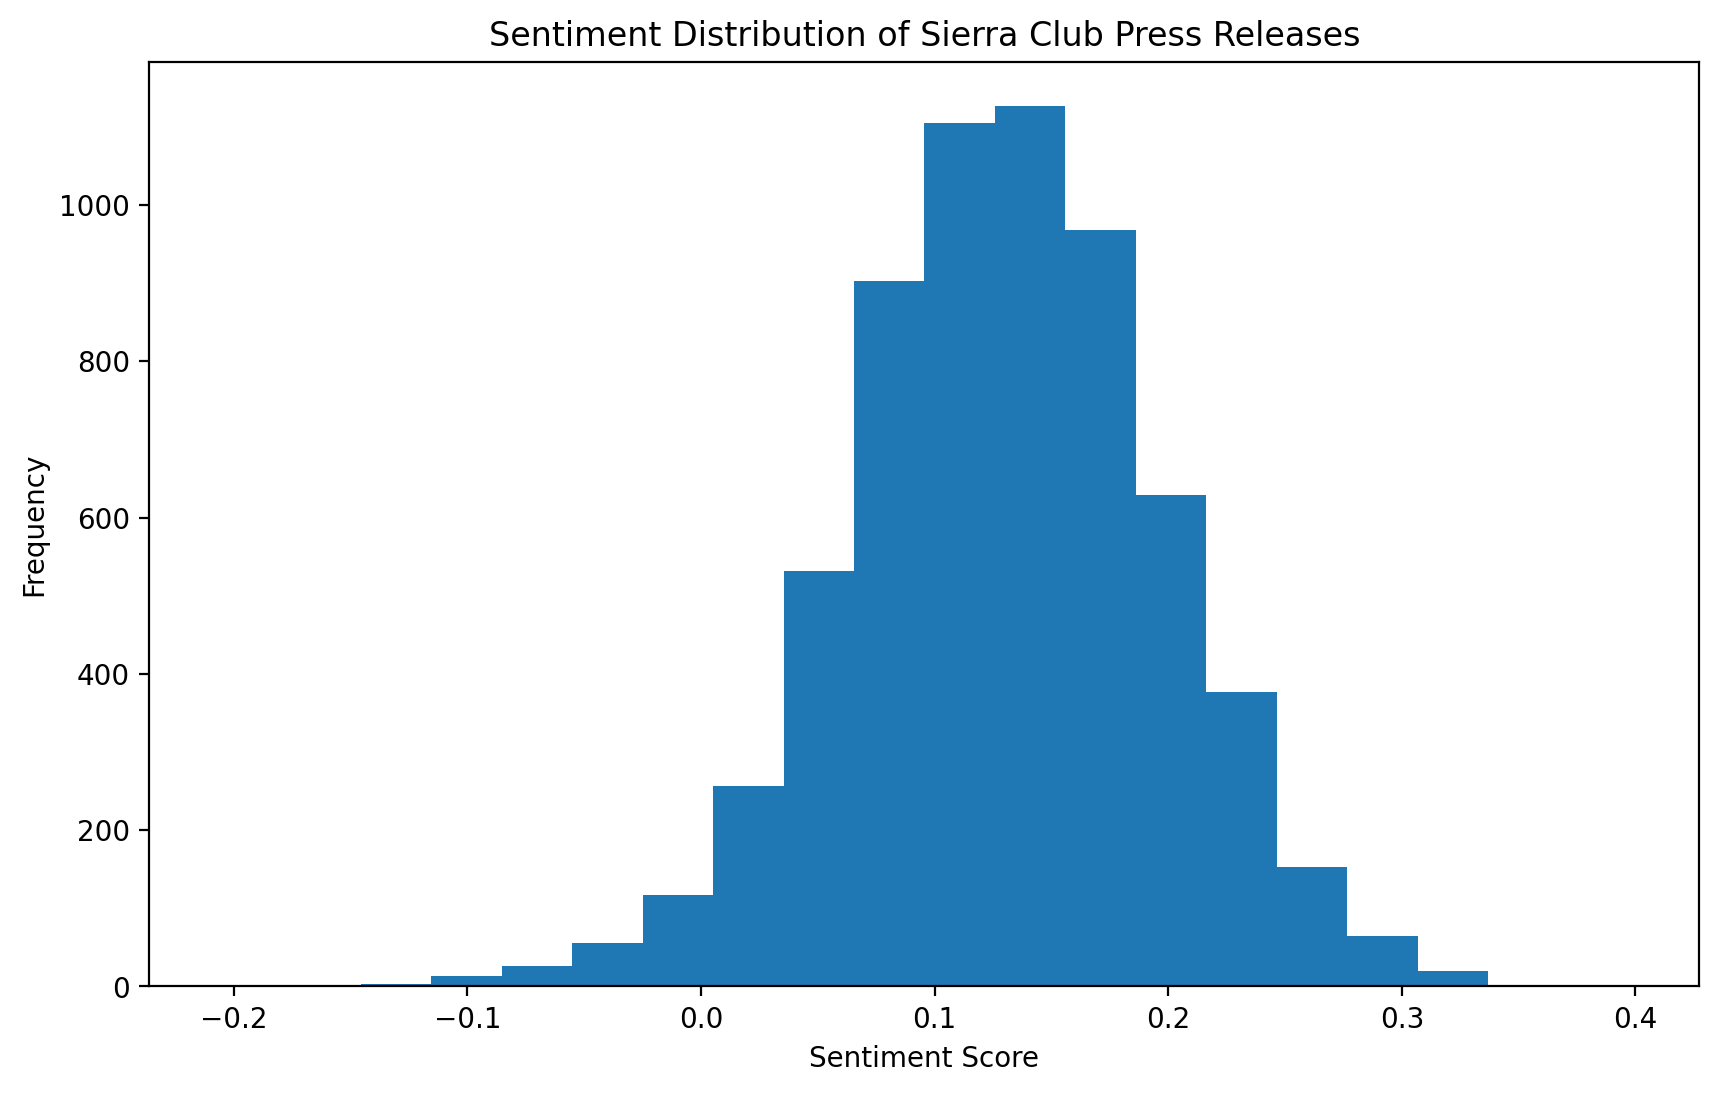

Average sentiment: 0.12952396179718417


In [22]:
from textblob import TextBlob


def get_sentiment(text):
    return TextBlob(text).sentiment.polarity


# Apply sentiment analysis to all articles
rdata_df["sentiment"] = rdata_df["content"].apply(get_sentiment)

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
plt.hist(rdata_df["sentiment"], bins=20)
plt.title("Sentiment Distribution of Sierra Club Press Releases")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

print(f"Average sentiment: {rdata_df['sentiment'].mean()}")

## 6. Text Representation

Let's create vector representations of our texts using TF-IDF.


In [23]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(rdata_df["processed_content"])

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Print the top 10 terms for the first document
first_doc_vector = tfidf_matrix[0]
top_terms = sorted(
    zip(feature_names, first_doc_vector.toarray()[0]), key=lambda x: x[1], reverse=True
)[:10]
print("Top 10 terms in the first document:")
for term, score in top_terms:
    print(f"{term}: {score}")

Top 10 terms in the first document:
texas: 0.3101051886326014
worker: 0.27622023052939987
agreement: 0.2288625126017953
facility: 0.21455232095761398
safety: 0.2009832958865476
must: 0.1752966664790094
energy: 0.1538819754578188
community: 0.15154887003653952
trade: 0.14915865499620834
commitment: 0.13363707315372284


## 7. Conclusion

In this lab, we've applied various NLP techniques to analyze Sierra Club press releases. We've performed text preprocessing, word frequency analysis, named entity recognition, sentiment analysis, and created TF-IDF representations of our texts. These techniques provide a foundation for more advanced analyses in future sessions.

## 8. Exercise

As an exercise, try to answer the following questions:

1. What are the most common themes in the Sierra Club press releases based on the word frequency analysis?
2. How does the sentiment of the press releases change over time? (Hint: You may need to use the 'timestamp' column)
3. What are the most common named entities mentioned in the press releases?

Submit your findings and code for these exercises.
